In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from keras.layers import GaussianNoise

In [3]:
tweets = pd.read_csv("/content/drive/My Drive/processed_train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("/content/drive/My Drive/processed_test.csv", usecols=['id','text'])
train_complete = pd.read_csv('/content/drive/My Drive/train_complete.csv')
test_complete = pd.read_csv('/content/drive/My Drive/test_complete.csv')

In [4]:
from sklearn.preprocessing import StandardScaler
scaled_train = StandardScaler().fit_transform(train_complete.loc[:, 'id':])
scaled_test = StandardScaler().fit_transform(test_complete.loc[:, 'id':])

In [5]:
scaled_train.shape

(7434, 218)

In [6]:
!pip install transformers

     |████████████████████████████████| 778kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 7.4MB/s 
     |████████████████████████████████| 3.0MB 6.8MB/s 
     |████████████████████████████████| 890kB 30.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=bd7940c72f5e314e5a75aa65298c92f8eed6fd982e528f489cd2899e71f3090c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Tensorflow

#### Bert

In [7]:
import tensorflow as tf
from transformers import TFBertModel
from transformers import BertTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
def bert_encode(data,maximum_len) :
  input_ids = []
  attention_masks = []
  for i in range(len(data.text)):
    encoded = tokenizer.encode_plus(data.text[i],
                                      add_special_tokens=True,
                                      max_length=maximum_len,
                                      pad_to_max_length=True,
                                      return_attention_mask=True, truncation=True)
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])   
  return np.array(input_ids),np.array(attention_masks)

In [10]:
train_input_ids,train_attention_masks = bert_encode(tweets, 40)
test_input_ids,test_attention_masks = bert_encode(test, 40)

print('Train length:', len(train_input_ids))
print('Test length:', len(test_input_ids))

Train length: 7434
Test length: 3263


In [11]:
def build_model(model_layer, learning_rate):
  input_ids = tf.keras.Input(shape=(40,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(40,),dtype='int32')
  meta_input = tf.keras.Input(shape = (scaled_train.shape[1], ))
  
  transformer_layer = model_layer([input_ids,attention_masks])
  
  output = transformer_layer[1]

  output = tf.keras.layers.Concatenate()([output, meta_input])

  
  
  output = tf.keras.layers.Dense(170,activation='relu')(output)

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)

  model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

In [12]:
model = build_model(bert, learning_rate = 6e-6)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 40, 768), (N 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 218)]        0                                 

In [13]:
history = model.fit([train_input_ids,train_attention_masks, scaled_train], tweets.target, epochs = 2, batch_size = 18, verbose=1)

Epoch 1/2
413/413 [==============================] - 3140s 8s/step - loss: 0.4789 - accuracy: 0.7863
Epoch 2/2
413/413 [==============================] - 3141s 8s/step - loss: 0.3634 - accuracy: 0.8539


In [14]:
preds_base = model.predict([test_input_ids, test_attention_masks, scaled_test])

In [15]:
prediction = []
for i in preds_base:
  if i >= 0.5:
    prediction.append(1)
  else:
    prediction.append(0)

In [16]:
test['target'] = prediction
submit = test.loc[:, ['id', 'target']]

0.8430891817346


In [17]:
submit.to_csv('/content/drive/My Drive/submit_bert_16.csv', index=False)

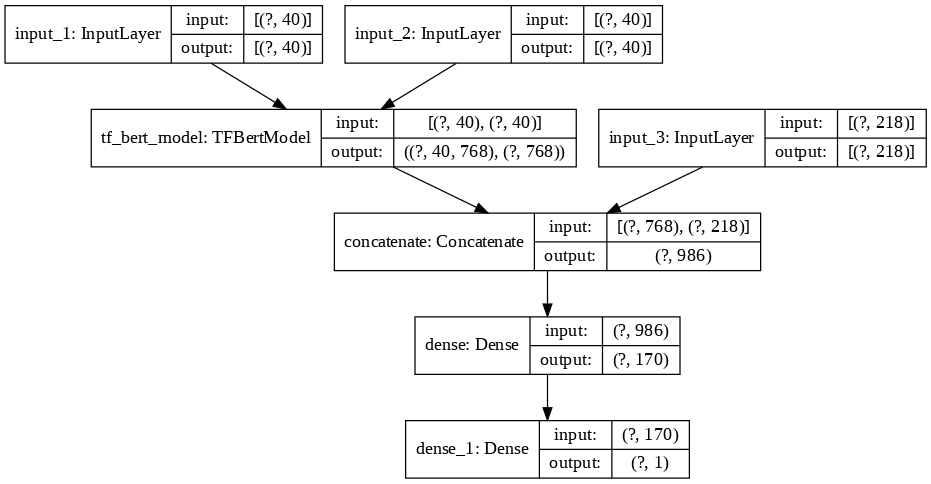

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)